In [1]:
# We are creating a dataset which is based on all of the dual-task trials per block and we are ignoring the practice trials
# The dataset is built by merging the results acquired in the paper created by Chris (---link---)

# Some columns are based on the significance provided in the said paper ( & maybe image here)
# The csv files we are merging into our dataset are provided below

# -MaxDeviationPerTrial.csv
# -maxnrDigitEnteredPerPPAndPerBlockPerTrial.csv
# -numberOfVisitsTrackerPerParticipantPerBlock.csv (trial data)
# samplesOutsideTrial.csv(*)
# sdVisTime.csv(*)
# tableForMeanTimeInDigitPerPPandPerBlock.csv(*) - merge the data ber block maybe?

# We are using the payoff function values provided in the meanVisTime.csv file
# The columns marked with star could be significant and we are testing to see the results with or without the said feature

In [12]:
# We first read the data and display it
final_rows = []

import pandas as pd
data = pd.read_csv('./data.csv');

print(data.shape)

display('loaded data!')

(1920, 9)


'loaded data!'

In [3]:
# We first split the data into 8 datasets
# and we calculate the mean value for each of the dataset
# in order to see how biased the data is in terms of 
# Radius, Noise and the payoff function

split_on = ['PayOffFunctionNumeric','Radius','Noise']

def split(dataSets,col):
    
    s = []
    
    for data in dataSets:
        
        if(col >= len(split_on)):
            return None
        
        values = {}
        
        for row in range(0,data.shape[ 0 ]):
            splitColumn = split_on[ col ]

            rowValue = data.iloc[ row ][ splitColumn ]
            
            if not rowValue in values:
                values[ rowValue ] = [ ]
                
            values[ rowValue ].append(row)
            
        for value in values:
            
            nextSet = []
            
            for row in values[value]:
                nextSet.append(data.iloc[ row ])
                
            s.append(pd.DataFrame(nextSet))
    res = split( s , col + 1 )
    
    if res is None:
        return s
    else: 
        return res
    
sets = [ data ]

split_sets = split(sets,0)

print('resulting length : ' +  str(len(split_sets)))


resulting length : 8


In [4]:
#We then take the top N percent of each of the sets

def get_by_split(sets,start, step, end, func):
    
    while start <= end:
        
        for dataSet in sets:
            
            sorted_set = dataSet.sort_values('Score',ascending=[False])
            func(start,sorted_set)
            
        start = start + step

per_tick = {}

#we save all of the datasets in this variable for later use
datasets = []

#We then compute the mean for the score column for the provided dataset
def mean(current_tick,item):

    meanVal = item['Score'].mean()
    
    if current_tick not in per_tick:
        per_tick[current_tick]= []
        
    per_tick[current_tick].append(meanVal)
    datasets.append(item)

get_by_split(split_sets, 1, 0.05, 1,mean)

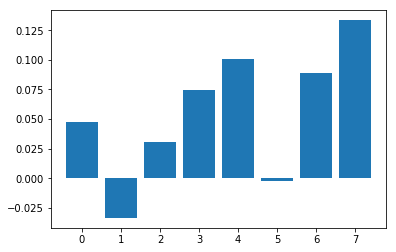

In [5]:
# We can now measure the distributions
# by testing different sizes

import matplotlib.pyplot as plt
import numpy as np

for tick_size in per_tick:
    tick_marks = np.arange(len(per_tick[tick_size]))
    fig, ax = plt.subplots()
    plt.bar(tick_marks,per_tick[tick_size])
    plt.show()

In [6]:
dictionary = {}

i = 0;
perc = 10
rowCounter = 0

print( 'there are ' + str(len(datasets)) + ' datasets' )

while(i <= 9):
    
    print('starting to aquire chunk ' + str(i))
    
    rp = []

    for next_set in datasets:
        size = int(next_set.shape[0] / perc)
        
        #starting point
        take = i * size
        start = take
        end = take + size
        next_items = next_set[start:end]
        
        frame = pd.DataFrame(next_items,columns=next_set.columns)
        rp.append(frame)
        
    dictionary[ i ] = pd.concat(rp)
    i = i + 1
    
print('done partitioning in chunks')

there are 8 datasets
starting to aquire chunk 0
starting to aquire chunk 1
starting to aquire chunk 2
starting to aquire chunk 3
starting to aquire chunk 4
starting to aquire chunk 5
starting to aquire chunk 6
starting to aquire chunk 7
starting to aquire chunk 8
starting to aquire chunk 9
done partitioning in chunks


In [7]:
# Then we split the data into training and testing sets by using the train test split function
from sklearn.model_selection import train_test_split


def run(func):
 splits = {}
 k = 0
 for k in dictionary:
     test_set = dictionary[k].copy()
     train_q = []
    
     for key in dictionary:
         if key == k: 
             continue
         train_q.append(dictionary[key])
        
     tr = pd.concat(train_q)
     
     y = tr[ 'Score' ]
     X = tr.drop( 'Score', 1 )
    
     y_t = test_set[ 'Score' ]
     X_t = test_set.drop('Score',1)
    
     func(X,y,X_t,y_t)
        
 print('done')
    

In [8]:
from sklearn.svm import SVR
from sklearn.tree import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# here be les dragons
sv = SVR(cache_size=7000)
tr = tree.DecisionTreeRegressor()
rfc = RandomForestRegressor()
lreg = LogisticRegression()

In [9]:
# Using grid search CV to tweak parameters
# We define a hyper parameter

from sklearn.model_selection import GridSearchCV

dict_grid = {
    sv: [
            {
                'C': [1, 10], 
                'kernel' : ['linear']
            }
    ],
    tr : [
            {
                #TODO:...
            }
    ],
    rfc: [
        {
            'n_estimators' : [5,10],
            
        }
    ],
    lreg: [
        {
            
        }
    ]
}

In [11]:
from sklearn.utils import shuffle

algorithms = [tr]
scores = ['r2']

def work(X,y,X_t,y_t):
 for score in scores:
    for algorithm in algorithms:
        grid = dict_grid[algorithm]
        clf = GridSearchCV(algorithm,grid , scoring = '%s' % score)
        clf.fit( X, y )
        print('best score: ' + str(clf.best_score_))
        
run(work)

best score: -0.498126730443
best score: -0.536072857075
best score: -1.05472924655
best score: -1.46342450515
best score: -0.995336076262
best score: -1.18407016589
best score: -1.21162423148
best score: -1.0362719418
best score: -1.10459847264
best score: -0.836015978981
done
